# Initial flow analysis

In [1]:
from os.path import join
from pandas import read_csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 160

In [2]:
base_path = join("run", "microChannel")

## Residuals

In [3]:
def parse_residual_file(path: str):
    df = read_csv(path, header=1, sep="\s+")
    names = df.columns[1:].tolist()
    df = df.iloc[:, :-1]
    df.columns = names
    return df

In [4]:
res_air = parse_residual_file(join(base_path, "postProcessing", "air", "solverInfo_air", "0", "solverInfo.dat"))
res_air.head()

,Time,U_solver,Ux_initial,Ux_final,Ux_iters,Uy_initial,Uy_final,Uy_iters,Uz_initial,Uz_final,...,h_solver,h_initial,h_final,h_iters,h_converged,p_rgh_solver,p_rgh_initial,p_rgh_final,p_rgh_iters,p_rgh_converged
0,0.000001,DILUPBiCGStab,1.000000,1.042240e-08,2,1.000000,4.537700e-09,2,1.000000,1.046410e-09,...,DILUPBiCGStab,0.008595,1.941600e-08,1,True,GAMG,0.461335,2.248710e-03,4,True
1,0.000003,DILUPBiCGStab,0.313650,5.473870e-10,2,0.524244,1.044190e-09,2,0.250763,2.739900e-10,...,DILUPBiCGStab,0.002581,2.094070e-09,1,True,GAMG,0.787643,7.822360e-03,150,True
2,0.000004,DILUPBiCGStab,0.120649,8.267680e-08,1,0.178372,7.060780e-10,2,0.935652,3.275530e-09,...,DILUPBiCGStab,1.000000,1.131030e-08,2,True,GAMG,0.000629,5.951010e-06,168,True
3,0.000006,DILUPBiCGStab,0.053799,7.312750e-08,1,0.066782,9.532650e-08,1,0.742369,5.227500e-09,...,DILUPBiCGStab,0.585409,1.431830e-08,2,True,GAMG,0.001107,1.086080e-05,162,True
4,0.000009,DILUPBiCGStab,0.037244,9.723960e-10,2,0.037206,6.431820e-10,2,0.747455,8.895180e-09,...,DILUPBiCGStab,0.442249,1.620290e-08,2,True,GAMG,0.000100,9.709170e-07,110,True


In [5]:
res_solid = parse_residual_file(join(base_path, "postProcessing", "solid", "solverInfo_solid", "0", "solverInfo.dat"))
res_solid.head()

,Time,h_solver,h_initial,h_final,h_iters,h_converged
0,0.000001,DICPCG,0.087590,3.649070e-07,5,True
1,0.000003,DICPCG,0.096130,9.701560e-07,4,True
2,0.000004,DICPCG,1.000000,1.655860e-07,6,True
3,0.000006,DICPCG,0.397925,3.311630e-07,5,True
4,0.000009,DICPCG,0.193635,2.575220e-07,5,True


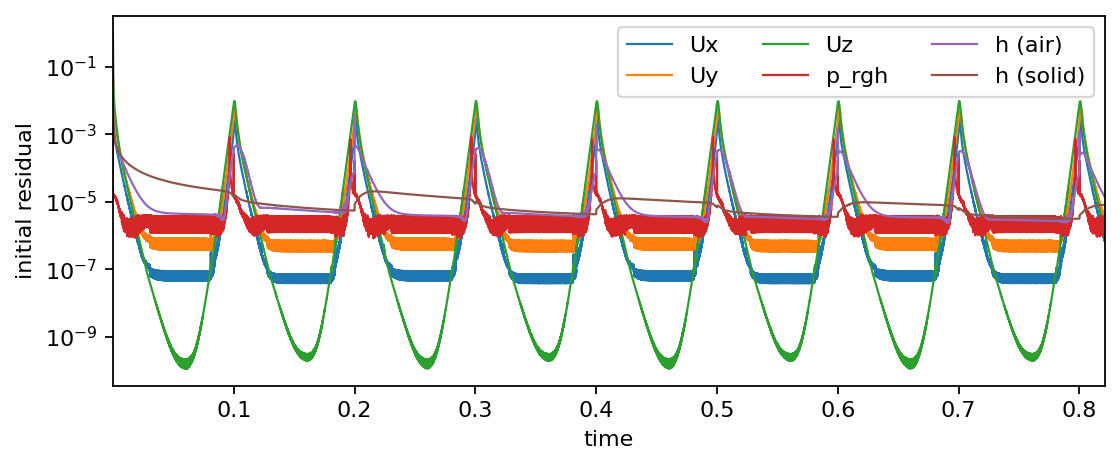

In [6]:
fig, ax = plt.subplots(figsize=(8, 3))

lw = 1
ax.plot(res_air.Time, res_air.Ux_initial, lw=lw, label="Ux")
ax.plot(res_air.Time, res_air.Uy_initial, lw=lw, label="Uy")
ax.plot(res_air.Time, res_air.Uz_initial, lw=lw, label="Uz")
ax.plot(res_air.Time, res_air.p_rgh_initial, lw=lw, label="p_rgh")
ax.plot(res_air.Time, res_air.h_initial, lw=lw, label="h (air)")
ax.plot(res_solid.Time, res_solid.h_initial, lw=lw, label="h (solid)")

ax.legend(ncol=3)
ax.set_xlabel("time")
ax.set_ylabel("initial residual")
ax.set_yscale("log")
ax.set_xlim(res_air.Time.values[0], res_air.Time.values[-1])
plt.show()

## Temperature and pressure difference

In [7]:
def parse_multiFieldValue(path: str):
    return read_csv(path, comment="#", sep="\s+", header=None, names=("time", "diff"))

In [8]:
delta_p = parse_multiFieldValue(join(base_path, "postProcessing", "delta_p", "0", "multiFieldValue.dat"))
delta_p.head()

,time,diff
0,0.000001,-0.000425
1,0.000003,33.785820
2,0.000004,5.160224
3,0.000006,12.109270
4,0.000009,11.783640


In [9]:
delta_T = parse_multiFieldValue(join(base_path, "postProcessing", "delta_T", "0", "multiFieldValue.dat"))
delta_T.head()

,time,diff
0,0.000001,-2.780000e+02
1,0.000003,-5.684342e-13
2,0.000004,2.000000e+01
3,0.000006,1.999998e+01
4,0.000009,2.000000e+01


In [10]:
def evaluate_inlet_velocity(time, Umag: float=0.5, period: float=0.2, transition: float=10):
    return Umag * np.tanh(np.sin(2*np.pi*time/period) * transition)

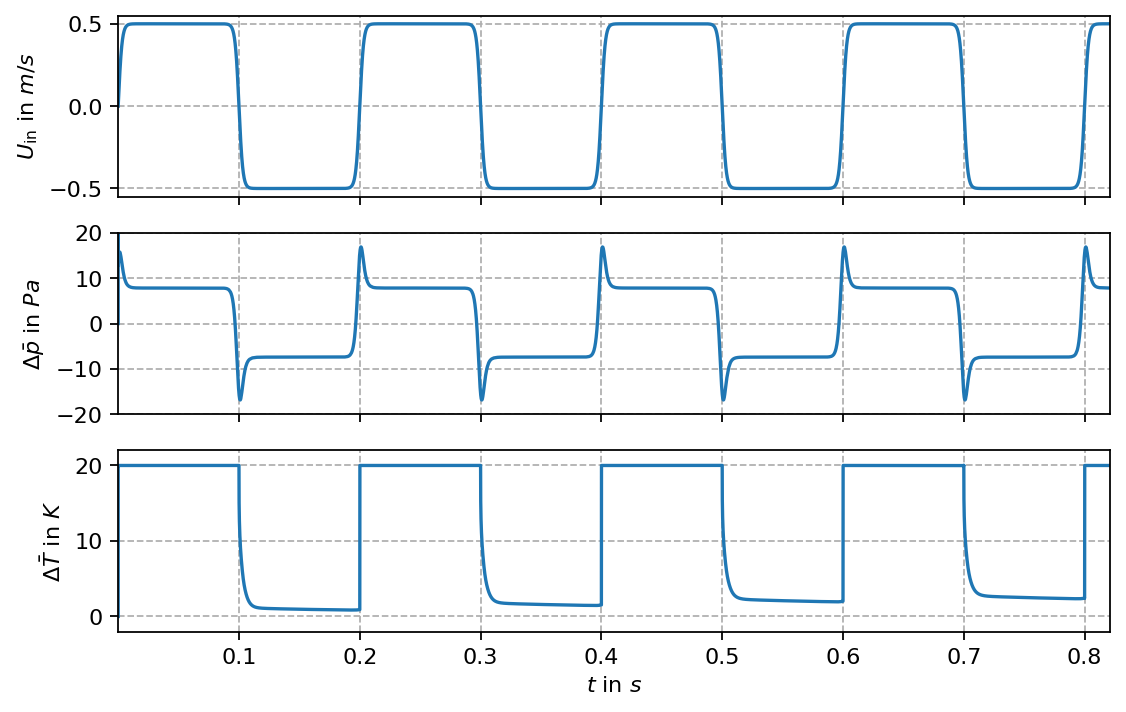

In [11]:
fig, axarr = plt.subplots(3, figsize=(8, 5), sharex=True)

t = delta_p.time.values
axarr[0].plot(t, evaluate_inlet_velocity(t))
axarr[1].plot(t, delta_p["diff"])
use_only = (delta_T["diff"] > -5) & (delta_T["diff"] < 25)
axarr[2].plot(delta_T.time[use_only], delta_T["diff"][use_only])
axarr[0].set_xlim(t[0], t[-1])
axarr[1].set_ylim(-20, 20)
axarr[2].set_ylim(-2, 22)
for ax in axarr:
    ax.grid(ls="--")
axarr[-1].set_xlabel(r"$t$ in $s$")
axarr[0].set_ylabel(r"$U_\mathrm{in}$ in $m/s$")
axarr[1].set_ylabel(r"$\Delta \bar{p}$ in $Pa$")
axarr[2].set_ylabel(r"$\Delta \bar{T}$ in $K$")
plt.show()

## Phase-averaged temperature (hot/cold)

In [12]:
def average_phases(dT, period: float=0.2):
    dT_temp = dT[(dT["diff"] > -5.0) & (dT["diff"] < 25)].copy()
    dT_temp["bin"] = pd.cut(dT_temp["time"], bins=np.arange(0, dT_temp["time"].max() + period/2, period/2), right=False)
    dT_avg = dT_temp.groupby("bin").mean().reset_index()
    return dT_avg.iloc[::2], dT_avg.iloc[1::2]

In [13]:
hot, cold = average_phases(delta_T)

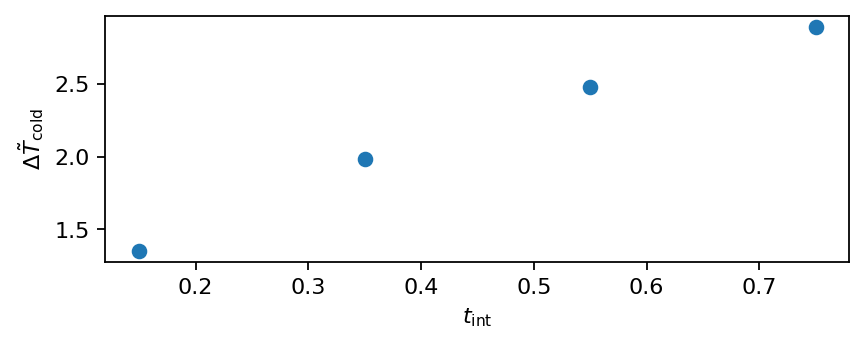

In [14]:
fig, ax = plt.subplots(figsize=(6, 2))

ax.scatter(cold["time"], cold["diff"])
ax.set_xlabel(r"$t_\mathrm{int}$")
ax.set_ylabel(r"$\Delta \tilde{T}_\mathrm{cold}$")
plt.show()